**THIS FILE CONTAINS THE NECESSARY CODE FOR MODELLING AND HYPERPARAMETER TUNING FOR XGB REGRESSOR.**

**Taking necessary files from drive**

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import sklearn

In [ ]:
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import StratifiedKFold,KFold
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from scipy.stats import uniform,randint
from sklearn.model_selection import train_test_split

In [ ]:
from xgboost import XGBRegressor

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
file=open('/content/drive/MyDrive/Project Energy Consumption/df_tr_red_final_modified.txt','rb')
df_tr_red_final=pickle.load(file)

In [ ]:
df_tr_red_final.reset_index(inplace=True)

In [ ]:
df_tr_red_final.drop(['index','timestamp'],axis=1,inplace=True)

In [ ]:
df_tr_red_final.drop('level_0',axis=1,inplace=True)

**TARGET TRANSFORMATION**

1.   AS THE METRIC IS RMSLE I AM TAKING THE LOG1P OF THE METER READINGS THEN TAKING THE EVALUATION METRIC TO BE RMSE.



In [ ]:
y_tr=np.log1p(df_tr_red_final['meter_reading'])
df_tr_red_final.drop('meter_reading',axis=1,inplace=True)

**FEATURE SELECTION**

1.   DOING FEATURE SELECTION USING XGB REGRESSOR WHICH HELPS TO PREVENT OVERFITTING ON THE TRAINING DATA.

2.   IN THIS WAY THE DIMENSIONS ARE ALSO REDUCED WHICH HELPS TO REDUCE THE TRAINING TIME OF THE MODEL.





In [ ]:
xgb_feat_sel=XGBRegressor(n_jobs=-1,tree_method='gpu_hist')
xgb_feat_sel.fit(df_tr_red_final,y_tr)

[07:43:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

**FEATURE IMPORTANCE PLOT**

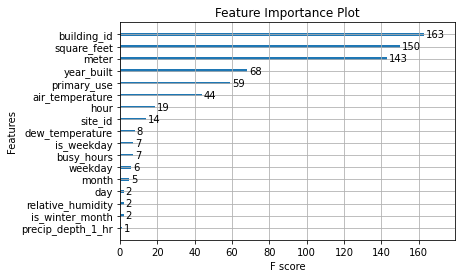

In [ ]:
xgb.plot_importance(xgb_feat_sel)
plt.title('Feature Importance Plot')
plt.show()

**DROPPING THE FEATURES WHICH ARE NOT IMPORTANT**

In [ ]:
df_tr_red_final.drop(['cloud_coverage','sea_level_pressure','wind_direction','wind_speed',
                      'is_summer_month','is_pub_holiday'],axis=1,inplace=True)

**DIVIDING THE DATA USING THE TRAIN TEST SPLIT**

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(df_tr_red_final,y_tr,test_size=0.2,random_state=0)

**HYPERPARAMETER TUNING**

1.   HERE I AM DOING THE HYPERPARAMETER TUNING USING RANDOMIZED SEARCH CV WITH THE USE OF GPU.

2.   IT HELPS THE MODEL TO FIND THE BEST PARAMS REQUIRED FOR TRAINING.



In [ ]:
x_cfl=XGBRegressor(tree_method='gpu_hist')
params={'n_estimators':[300,500,1000,1500,2000],
        'learning_rate':[0.01,0.03,0.05,0.1],
        'max_depth':[3,5,7,9],
        'colsample_bytree':[0.5,0.8,0.9,1]}
random_clf=RandomizedSearchCV(x_cfl,params,scoring='neg_root_mean_squared_error',n_jobs=-1,cv=3,verbose=10,random_state=0,n_iter=10)
random_clf.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 27.4min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 30.1min finished


[08:13:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                                          tree_method='gpu_hist', verbosity=1),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'colsampl

**BEST PARAMS**

In [ ]:
random_clf.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 9,
 'n_estimators': 500}

**BEST SCORE**

In [ ]:
random_clf.best_score_

-0.7280361453692118

In [ ]:
predict=random_clf.predict(X_test)
cv_score=np.sqrt(mean_squared_error(y_test,predict))

**SCORE ON THE TEST SET USING THE BEST PARAMS FOUND FROM HYPERPARAMETER TUNING**

In [ ]:
cv_score

0.7237433

**FITTING THE BEST MODEL ON THE TRAINING SET**

In [ ]:
xgb_reg=XGBRegressor(n_estimators=500,max_depth=9,learning_rate=0.1,colsample_bytree=0.8,tree_method='gpu_hist')
xgb_model=xgb_reg.fit(df_tr_red_final,y_tr)

[08:15:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


**STORING THE BEST MODEL IN THE FORM OF PICKLE FILE AND DUMPING IT INTO DRIVE**

In [ ]:
filename='xgb_model_modified.txt'
my_file=open(filename,'wb')

In [ ]:
pickle.dump(xgb_model,my_file)